In [7]:
import render
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import ipywidgets as widgets


device = "cuda"

def logit(p):
    return torch.log(p) - torch.log(1 - p)


def soft_render_square(
    square, location, background, background_depth=-1e-3, color_sharpness=1e-4, blur=1e-4
):
    """Draws a square on a canvas whose xy limits are [-1, 1].

    Follows equations (2) and (3) in
    https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Soft_Rasterizer_A_Differentiable_Renderer_for_Image-Based_3D_Reasoning_ICCV_2019_paper.pdf

    Args
        square
        location [2]
        background [num_channels, num_rows, num_cols] -- this is the background color C_b in
            equation (2)
        background_weight [] (default 1.): ϵ in equation (3)
        color_sharpness [] (default 1e-4): γ in equation (3)
        blur [] (default 1e-4): this is the σ in equation (1)

    Returns
        new_canvas [num_channels, num_rows, num_cols]
    """
    # Init
    device = location.device
    num_channels, num_rows, num_cols = background.shape

    # Canvas xy
    # [num_rows, num_cols]
    canvas_x, canvas_y = render.get_canvas_xy(num_rows, num_cols, device)
    canvas_xy = torch.stack([canvas_x, canvas_y], dim=-1)

    # Get render log prob
    # --Foreground object (treat depth z = -1) [num_rows, num_cols]
    depth = -1
    square_render_log_prob = (
        render.get_render_log_prob(render.get_min_edge_distance(square, location, canvas_xy), blur=blur)
        + depth / color_sharpness
    )
    # --Background [num_rows, num_cols]
    background_render_log_prob = (
        torch.ones_like(square_render_log_prob) * background_depth / color_sharpness
    )

    # Compute color weight (equation (3))
    # [num_rows, num_cols]
    square_weight, background_weight = F.softmax(
        torch.stack([square_render_log_prob, background_render_log_prob]), dim=0
    )
    
#     return square_weight[None] * square.color[:, None, None] #  + background_weight[None] * background
    return background_weight[None] * background
#     return square_weight[None] * square.color[:, None, None] + background_weight[None] * background


In [26]:
gamma = 1e-4
epsilon = -1
sigma = 1e-4
# w = widgets.FloatSlider(
#     value=1e-4,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='Gamma',
#     disabled=False,
#     continuous_update=True,
#     orientation='horizontal',
#     readout=True,
#     readout_format='.1f',
# )
# w

tensor(0.2000, device='cuda:0')
tensor([1., 0., 0.], device='cuda:0')
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)
tensor([1., 0., 0.], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(-2.6701, device='cuda:0')
None
tensor(-128., device='cuda:0')
tensor(12276.5586, device='cuda:0')


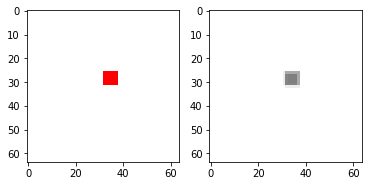

In [27]:
blank_canvas = render.init_canvas(device)

true_square = render.Square("A", torch.tensor([1., 0., 0.], device=device), torch.tensor(0.2, device=device))
true_location = torch.tensor([0., 0.], device=device)
true_img = render.render_square(true_square, true_location, blank_canvas)
print(true_square.size)
print(true_square.color)

square = render.LearnableSquare("0").to(device)
size = torch.tensor(0.2, device=device)
color = torch.tensor([1., 0., 0.], device=device)
square.raw_size.data = size.log()
square.raw_color.data = logit(color)
print(square.size)
print(square.color)

location = torch.tensor([0., 0.], device=device)
color_sharpness = nn.Parameter(torch.tensor(gamma, device=device))
blur = nn.Parameter(torch.tensor(sigma, device=device))
img = soft_render_square(square, location, blank_canvas,
                         background_depth=epsilon, color_sharpness=color_sharpness, blur=blur)

loss = ((img - true_img)**2).sum()
loss.backward()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(true_img.cpu().permute(1, 2, 0))
axs[1].imshow(img.cpu().detach().permute(1, 2, 0))

print(square.raw_size.grad)
print(square.raw_color.grad)
print(color_sharpness.grad)
print(blur.grad)